In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from scipy import stats
import math
from scipy.sparse import csc_matrix
import random
import operator
import scipy.io
import collections
import heapq

import csv
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from math import log
from scipy import stats
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = 4, 4
subSize=10000

In [5]:
def load_restaurant_dataset():
    path = 'dataset_ubicomp2013_checkins.txt'
    infile = open(path, 'r')
    a = set()
    b = set()
    edges = []
    for line in infile:
        s=line.strip().split(None)
        u=-1*int(s.pop(0)) -10
        v=int(s.pop(0))
        a.add(u)
        b.add(v)
        edges.append((u,v))
    top_nodes = {}
    bottom_nodes = {}
    count = 0 
    for x in a:
        top_nodes[x] = count
        count = count + 1
    count  = 0    
    for y in b:
        bottom_nodes[y] = count
        count  = count + 1
    
    A = np.zeros((len(a),len(b)))
    for edge in edges:
        e1 = top_nodes[edge[0]]
        e2 = bottom_nodes[edge[1]]
        A[e1, e2] = 1
    
    A = np.dot(A,A.T)
    for i in range(0,A.shape[0]):
        for j in range(0,A.shape[1]):
            if i == j :
                A[i,j] = 0
            else:
                if A[i,j] != 0:
                  A[i,j] = 1
                else:
                  A[i,j] = 0
          
                                     
    G=nx.from_numpy_matrix(A)
    return G
G = load_restaurant_dataset()

In [6]:
# Take subgraph for less computations
# sub_edges=random.sample(list(diG.edges()),subSize) <-- wrong as it definitely loses properties of original graph
# G=nx.Graph(sub_edges)
G.remove_edges_from(G.selfloop_edges())


# the one-fold of YES edges
total_edges=list(G.edges())
np.random.shuffle(total_edges)
l=int(len(total_edges)*0.7) # keep 70% graph, 30% for growth labels
# edges_0 exist only for common neighbors
edges_0,ETEs = total_edges[:l], total_edges[l:]

"""
 Use all the edges present in the network as "YES", and randomly choose equal number of "Non-existing" edges as "NO". 
"""
# Randomly choose equal sized (entire)fold of NO edges
nonETEs=random.sample(list(nx.non_edges(G)),len(ETEs))
total_edges=ETEs+nonETEs #total in consideration

xe,nxe=len(ETEs),len(nonETEs)
methods=['CN','JC','AA','RA','PA']

## 
## NOTE: HAVENT CHECKED FOR CONNECTIVITY MAINTAINED.
# len(nx.bfs_tree(G,nodelist[0]).edges())
# # extract matrix in order, and convert to dense representation
# A = nx.adjacency_matrix(G, nodelist=nodelist).todense()
N=G.number_of_nodes()
# store index for node index
nodelist = list(G.nodes())

In [7]:
print(nx.info(G))
print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))
print(nx.is_directed(G))

Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 58810
Average degree:  57.0971
2060
58810
False


In [8]:
def nonedges(G,u):  #a generator with (u,v) for every non neighbor v
    for v in nx.non_neighbors(G, u):
        yield (u, v)

In [9]:
for u in G.nodes():
    adar = nx.adamic_adar_index(G,nonedges(G,u))
    for v in nx.non_neighbors(G, u):
        com = nx.common_neighbors(G,u,v)
    jac = nx.jaccard_coefficient(G,nonedges(G,u))
    res = nx.resource_allocation_index(G,nonedges(G,u))
    pre = nx.preferential_attachment(G,nonedges(G,u))
#     tenlargest = heapq.nlargest(10, pred, key = lambda x: x[2])
#     print(tenlargest)
#     for u,v,p in pred:
#         print(u,v,p)

In [10]:
allm={m:{} for m in methods}
toponame="datasetFourSquare"+".csv"
with open(toponame,"w",newline="", encoding="utf-8") as f:   # binary mode for windows \r\n prob
    writer = csv.writer(f, delimiter=',')        
    writer.writerow(['node1','node2']+methods+['label'])

#     for i,n1 in enumerate(nodelist):
#         for j,n2 in enumerate(nodelist):
#             if(i==j):
#                 continue
    for p in total_edges:
            n1,n2=p
            ngh1 = set(G[n1])
            ngh2 = set(G[n2])
            inter = ngh1.intersection(ngh2) # ngh1 & ngh2
            inter_l = len(inter)
            union_l = len(ngh1.union(ngh2)) #ngh1 | ngh2            
            
            allm['CN'][p]=inter_l
            allm['JC'][p]=(inter_l/union_l) if union_l else 0.0
            allm['AA'][p]=sum([1/log(len(G[z])) for z in inter]) # denom cant be zero as atleast 2 edges
            allm['RA'][p]=sum([1/len(G[z]) for z in inter])
            allm['PA'][p]=len(ngh1)*len(ngh2)
            
            # + can add your own features
            writer.writerow(list(p) + [allm[m][p] for m in methods] + [1 if G.has_edge(n1,n2) else 0])

In [11]:
# library & dataset
import seaborn as sns
import pandas_profiling
import pandas as pd
df=pd.read_csv(toponame)
df=df[methods]
#df.profile_report()

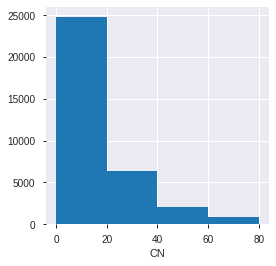

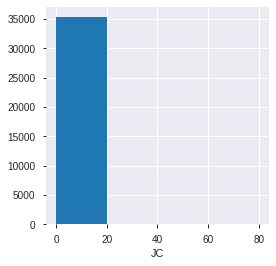

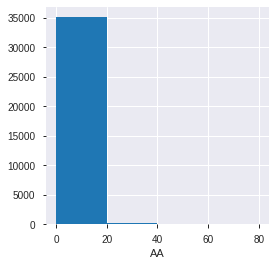

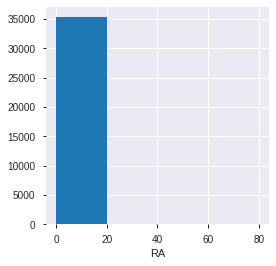

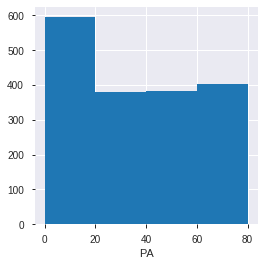

In [12]:
for m in methods:
    plt.subplots()
    plt.xlabel(m)
    df[m].hist(align='mid',bins=[0,20,40,60,80,])#plot(kind='kde')
    


          CN        JC        AA        RA        PA
CN  1.000000  0.780056  0.998493  0.936382  0.764292
JC  0.780056  1.000000  0.783131  0.752337  0.329169
AA  0.998493  0.783131  1.000000  0.953669  0.765692
RA  0.936382  0.752337  0.953669  1.000000  0.739899
PA  0.764292  0.329169  0.765692  0.739899  1.000000


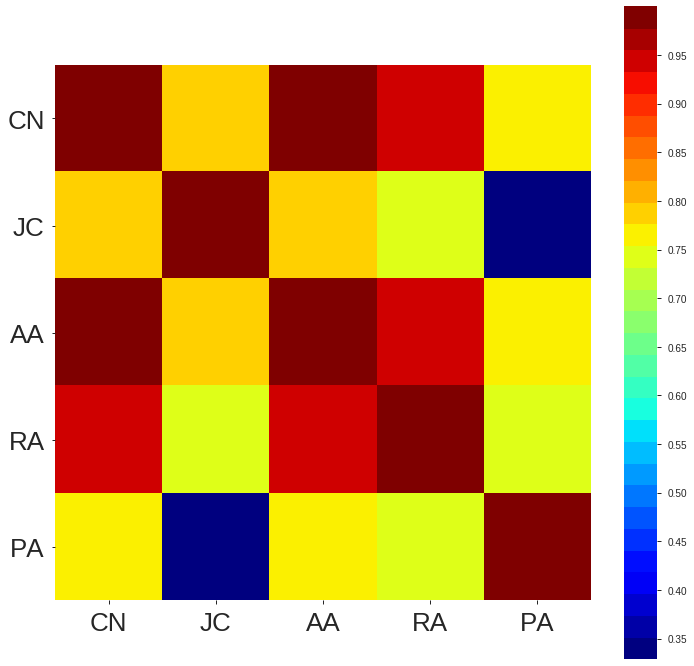

In [13]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(axis='both')
    labels=['X']+methods
    ax1.set_xticklabels(labels,fontsize=26)
    ax1.set_yticklabels(labels,fontsize=26)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=list([x/100 for x in range(0,100,5)]))
    plt.show()

print(df.corr())
correlation_matrix(df)

In [14]:
#precision and recall for topological algorithms#
def precision_recall(score_labels, k):
    l=len(score_labels)
    thresh = score_labels[int(l*k)][0]           #all above threshold will have greater cn/jj/aa value. so, label should be 1
    truepos = 0
    falsepos = 0
    falseneg=0
    trueneg =0
    for i in range(0, l):
        if(score_labels[i][1]==1 and score_labels[i][0]>=thresh):
            truepos+=1
        elif (score_labels[i][1]==0 and score_labels[i][0]>=thresh):
            falsepos+=1
        if(score_labels[i][1]==0 and score_labels[i][0]<=thresh):
            trueneg+=1
        elif(score_labels[i][1]==1 and score_labels[i][0]<=thresh):
            falseneg+=1
    
    truepos = float(truepos)
    trueneg = float(trueneg)
    falsepos = float(falsepos)
    falseneg = float(falseneg)
    p = '%.3f'%float(truepos/(truepos+falsepos))
    r = '%.3f'%float(truepos/(truepos+falseneg))
    return [p,r]

all_edges_score,nonExisting={},{}
for m in methods:
    nonExisting[m] = sorted([(e,allm[m][e]) for e in nonETEs],key=lambda x:x[1])
    all_edges_score[m] = sorted([(allm[m][e],1) for e in ETEs]+[(allm[m][e],0) for e in nonETEs],key=lambda x:x[0],reverse=True)


In [15]:
all_edges_score['CN'][:10]

[(185, 1),
 (182, 1),
 (167, 1),
 (163, 1),
 (160, 1),
 (154, 1),
 (152, 1),
 (146, 1),
 (145, 1),
 (144, 1)]

In [16]:
""" 
For AUC: 
for two node pairs p1,p2 
AUC = P( p1.score > p2.score and p1 is existing and p2 is non-existing )
above value is averaged over all node pairs
"""
# for name,edges in zip(["metrics_for_existing"+".csv","metrics_for_nonexisting"+".csv"],[edgelist,nonedgelist]):
topoaucname="topological_metricsFourSquare"+".csv"
"""
AvgAUC =(n1 + 0.5n2)/n ∗ p
where 
n1 = number of times link prediction score for existing test edge is greater than other non-existing test edges, 
n2 = number of times link prediction score for existing test edge is equal to other non-existing test edges,
n = number of non-existing test edges, and p = number of existing test edges.
"""
# Source for formula: https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxha2FzaGFuaWwyNjAxfGd4OjI5Y2ExYmExMGI0OWE0ODc
with open(topoaucname,"w",newline="", encoding="utf-8") as f:   # binary mode for windows \r\n prob
    writer = csv.writer(f, delimiter=',')        
    writer.writerow(['node1','node2']+methods)
    sumAUC={m:0 for m in methods}
    total={m:0 for m in methods}
    for p in ETEs:
        row=[p[0],p[1]]
        
        for m in methods:        
            score=allm[m][p]
            count=0.0
            for s in nonExisting[m]:
                if(s[1]<score):
                    count+=1.0
                elif(s[1]==score):
                    count+=0.5
                else:
                    break
            local_auc = count/nxe
            sumAUC[m]+=local_auc            
            total[m]+=1
            row.append(local_auc)
            
        writer.writerow(row)
    row=['overall AUC','-']
    row2=['PR@25%','-']
    row3=['PR@50%','-']
    row4=['PR@75%','-']
    for m in methods:
        assert(total[m]==xe)
        row.append(sumAUC[m]/xe) # avg 
        row2.append(precision_recall(all_edges_score[m],k=0.25))
        row3.append(precision_recall(all_edges_score[m],k=0.50))
        row4.append(precision_recall(all_edges_score[m],k=0.75))
    print(row)
    writer.writerow(row)
    print(row2)
    writer.writerow(row2)
    print(row3)
    writer.writerow(row3)
    print(row4)
    writer.writerow(row4)

#  If time: do Precision@K
#
#

['overall AUC', '-', 0.9655434261376779, 0.9766974940577503, 0.9724349510134176, 0.9846810372763894, 0.8510577620273434]
['PR@25%', '-', ['0.986', '0.488'], ['1.000', '0.500'], ['0.991', '0.495'], ['0.999', '0.499'], ['0.882', '0.441']]
['PR@50%', '-', ['0.894', '0.892'], ['0.917', '0.918'], ['0.916', '0.916'], ['0.941', '0.941'], ['0.773', '0.773']]
['PR@75%', '-', ['0.641', '0.992'], ['0.664', '0.996'], ['0.664', '0.997'], ['0.664', '0.997'], ['0.632', '0.949']]


In [17]:
methods

['CN', 'JC', 'AA', 'RA', 'PA']

In [18]:
df = np.genfromtxt(toponame, delimiter=',',skip_header=1)

for m in range(2,2+len(methods)):
    print(m,df[2:,m].max())
    df[2:,m] = df[2:,m] / df[2:,m].max()
x=df[:,2:-1]
y=df[:,-1]
y

2 185.0
3 0.9764705882352941
4 38.975936949810276
5 1.9207304421533495
6 197548.0


array([1., 1., 1., ..., 0., 0., 0.])

In [19]:
import math
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

def reportClassifier(name,y_test,y_pred,scores=None):
    print("\n\t\t"+name)
    if(scores is not None):
        print("\nCross Validation Scores")
        print(scores)
    print("\nAccuracy: ",accuracy_score(y_test,y_pred))
    print("\nClassification Report")
    print(classification_report(y_test,y_pred))    
    print("\nConfusion Matrix")
    print(confusion_matrix(y_test,y_pred))
    try:
        print("\nROC AUC score")
        print(roc_auc_score(y_test, y_pred))
    except ValueError:
        print("Warning: Only one class in this fold")

def mean(x):
    return sum(x)/float(len(x))
 
def stddev(x):
    if(len(x)<2):
        return -1;
    avg = mean(x)
    variance = sum([pow(x-avg,2) for x in x])/float(len(x)-1)
    return math.sqrt(variance)

def getFeatureProbability(x, mean, stddev):
    if(stddev==0):# spike in gaussian
        return 1 if x==mean else 0
    exp = math.exp(-1*( math.pow(x-mean,2) / (2*math.pow(stddev,2))))
    return (1 / (math.sqrt(2*math.pi) * stddev)) * exp

def splitByLabel(x,y):
    yes,no=[],[]
    for i in range(len(y)):
        if(y[i]):
            yes.append(x[i,:])
        else:
            no.append(x[i,:])
    return yes,no

def getMeanStds(x_train):
    mean_stds=[]
    for i in range(len(x_train[0])): # 5 times
        mean_stds.append((mean(x_train[i]),stddev(x_train[i])))
    return mean_stds


def naive_bayes_gaussian(x_train,y_train):    
    h,w=x_train.shape
    labelYes,labelNo= splitByLabel(x_train,y_train)
    # Train part:
    yes_mean_stds=getMeanStds(labelYes)
    no_mean_stds=getMeanStds(labelNo)
    return yes_mean_stds,no_mean_stds

def predict_naive_bayes(x_test,yms,nms):    
    h,w=x_test.shape
    y_pred=[]
    #     p(Ci)
    p=len(yms)/(len(yms)+len(nms))
    # test part
    for i in range(h):
        x=x_test[i]
        p_yes,p_no=p,1-p
        for j in range(w): # 5 times
            m,s=yms[j]
            nm,ns=nms[j]
            p_yes *= getFeatureProbability(x[j],m,s)
            p_no *= getFeatureProbability(x[j],nm,ns)
        if(p_yes>=p_no):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [20]:
# For classifers: make five-folds
# foldSize=xe//5
# edge_folds = [ETEs[i*foldSize:(i+1)*foldSize] if i<4 else ETEs[i*foldSize:] for i in range(0,5)]
# nonedge_folds = [ETEs[i*foldSize:(i+1)*foldSize] if i<4 else ETEs[i*foldSize:] for i in range(0,5)]

kf=KFold(n_splits=5,shuffle=True)
# for i in range(0,5):
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    yes_mean_stds,no_mean_stds = naive_bayes_gaussian(x_train,y_train)
    y_pred = predict_naive_bayes(x_test,yes_mean_stds,no_mean_stds)
    #reportClassifier("GaussianUD",y_test,y_pred)

    #for trial-
    b=GaussianNB()
    b.fit(x_train,y_train)
    y_pred=b.predict(x_test)
    reportClassifier("GaussianNB",y_test,y_pred)        


		GaussianNB

Accuracy:  0.9071975063757438

Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      3546
         1.0       0.97      0.84      0.90      3512

    accuracy                           0.91      7058
   macro avg       0.91      0.91      0.91      7058
weighted avg       0.91      0.91      0.91      7058


Confusion Matrix
[[3457   89]
 [ 566 2946]]

ROC AUC score
0.9068697830145166

		GaussianNB

Accuracy:  0.9105852345189174

Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91      3463
         1.0       0.97      0.85      0.91      3594

    accuracy                           0.91      7057
   macro avg       0.92      0.91      0.91      7057
weighted avg       0.92      0.91      0.91      7057


Confusion Matrix
[[3383   80]
 [ 551 3043]]

ROC AUC score
0.9117937843915108

		GaussianNB

Accuracy:  0.9074677625053139

Classi

In [22]:
    svclassifier = SVC(kernel='linear')  
    svclassifier.fit(x_train, y_train)
    scores = cross_val_score(svclassifier,x, y, cv=5)
    y_pred = svclassifier.predict(x_test)
    reportClassifier("SVM",y_test,y_pred,scores)


		SVM

Cross Validation Scores
[0.94786058 0.95041088 0.94573534 0.94316893 0.94756236]

Accuracy:  0.9436020972084456

Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      3561
         1.0       0.96      0.92      0.94      3496

    accuracy                           0.94      7057
   macro avg       0.94      0.94      0.94      7057
weighted avg       0.94      0.94      0.94      7057


Confusion Matrix
[[3442  119]
 [ 279 3217]]

ROC AUC score
0.9433884643387525


In [23]:
    clf = tree.DecisionTreeClassifier()
    scores = cross_val_score(clf,x, y, cv=5)
    clf = clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    reportClassifier("Decision Tree",y_test,y_pred,scores)


		Decision Tree

Cross Validation Scores
[0.94035137 0.93624256 0.93581751 0.9356576  0.9375    ]

Accuracy:  0.9297151764205753

Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      3561
         1.0       0.93      0.93      0.93      3496

    accuracy                           0.93      7057
   macro avg       0.93      0.93      0.93      7057
weighted avg       0.93      0.93      0.93      7057


Confusion Matrix
[[3320  241]
 [ 255 3241]]

ROC AUC score
0.929690938960529


In [32]:
newdf = pd.DataFrame(x, columns=methods)
newdf = newdf.drop(['CN', 'AA'], axis =1)

In [25]:
### PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(newdf)
principalDf = pd.DataFrame(data = pc, columns = ['pc_1', 'pc_2'])
# newdf['pc_1'] = principalDf['pc_1']
# newdf['pc_2'] = principalDf['pc_2']

In [33]:
## SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(2)
sv = svd.fit_transform(newdf)
singulardf = pd.DataFrame(data = sv, columns = ['sv_1', 'sv_2'])
newdf['sv_1'] = singulardf['sv_1']
newdf['sv_2'] = singulardf['sv_2']

In [27]:
newdf = np.array(newdf)

In [31]:
kf=KFold(n_splits=5,shuffle=True)
# for i in range(0,5):
for train_index, test_index in kf.split(newdf):
    x_train, x_test = newdf[train_index], newdf[test_index]
    y_train, y_test = y[train_index], y[test_index]
    yes_mean_stds,no_mean_stds = naive_bayes_gaussian(x_train,y_train)
    y_pred = predict_naive_bayes(x_test,yes_mean_stds,no_mean_stds)
    #reportClassifier("GaussianUD",y_test,y_pred)

    #for trial-
    b=GaussianNB()
    b.fit(x_train,y_train)
    y_pred=b.predict(x_test)
    reportClassifier("GaussianNB",y_test,y_pred, scores)


		GaussianNB

Cross Validation Scores
[0.95097761 0.94672712 0.94176821 0.93835034 0.94529478]

Accuracy:  0.8969963162368944

Classification Report
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91      3538
         1.0       0.98      0.81      0.89      3520

    accuracy                           0.90      7058
   macro avg       0.91      0.90      0.90      7058
weighted avg       0.91      0.90      0.90      7058


Confusion Matrix
[[3477   61]
 [ 666 2854]]

ROC AUC score
0.8967770376175549

		GaussianNB

Cross Validation Scores
[0.95097761 0.94672712 0.94176821 0.93835034 0.94529478]

Accuracy:  0.9035000708516366

Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91      3519
         1.0       0.98      0.82      0.90      3538

    accuracy                           0.90      7057
   macro avg       0.91      0.90      0.90      7057
weighted avg       0.9

In [29]:
clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf,newdf, y, cv=5)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
reportClassifier("Decision Tree",y_test,y_pred,scores)


		Decision Tree

Cross Validation Scores
[0.93355058 0.93100028 0.93355058 0.93409864 0.93877551]

Accuracy:  0.9290066600538472

Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      3549
         1.0       0.93      0.93      0.93      3508

    accuracy                           0.93      7057
   macro avg       0.93      0.93      0.93      7057
weighted avg       0.93      0.93      0.93      7057


Confusion Matrix
[[3306  243]
 [ 258 3250]]

ROC AUC score
0.9289919141467251


In [30]:
svclassifier = SVC(kernel='linear')  
svclassifier.fit(x_train, y_train)
scores = cross_val_score(svclassifier,newdf, y, cv=5)
y_pred = svclassifier.predict(x_test)
reportClassifier("SVM",y_test,y_pred,scores)


		SVM

Cross Validation Scores
[0.95097761 0.94672712 0.94176821 0.93835034 0.94529478]

Accuracy:  0.9424684710216806

Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      3549
         1.0       0.96      0.92      0.94      3508

    accuracy                           0.94      7057
   macro avg       0.94      0.94      0.94      7057
weighted avg       0.94      0.94      0.94      7057


Confusion Matrix
[[3412  137]
 [ 269 3239]]

ROC AUC score
0.9423578533853949


,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.040753,0.000799,0.046109,0.001765
1,0.039832,0.000784,0.045429,0.002071
2,0.039024,0.000514,0.045061,0.001601
3,0.038542,0.000348,0.044806,0.001627
4,0.038386,0.000331,0.044862,0.001791
5,0.038230,0.000556,0.044777,0.001811
6,0.037947,0.000804,0.044862,0.001876
7,0.037848,0.000781,0.044522,0.002041
8,0.037423,0.000612,0.044352,0.002480
9,0.037309,0.000713,0.044664,0.002330


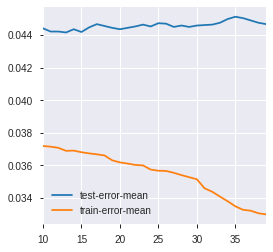

In [37]:
import xgboost as xgb
dtrain = xgb.DMatrix(newdf, label = y)

params = {"objective" : "binary:logistic"}
model = xgb.cv(params, dtrain, num_boost_round = 40) 
model.loc[10:, ['test-error-mean', 'train-error-mean']].plot()
model

In [41]:
model = xgb.XGBClassifier(objective = 'binary:logistic')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
reportClassifier("XGB",y_test,y_pred,scores)


		XGB

Cross Validation Scores
[0.95097761 0.94672712 0.94176821 0.93835034 0.94529478]

Accuracy:  0.9556468754428227

Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      3539
         1.0       0.97      0.94      0.95      3518

    accuracy                           0.96      7057
   macro avg       0.96      0.96      0.96      7057
weighted avg       0.96      0.96      0.96      7057


Confusion Matrix
[[3435  104]
 [ 209 3309]]

ROC AUC score
0.9556022062935203
